In [92]:
import tensorflow as tf

# Eager Execution을 전역적으로 활성화
tf.config.run_functions_eagerly(True)

# tf.data 파이프라인에 대해 Eager Execution을 강제 활성화
tf.data.experimental.enable_debug_mode()

# 이후의 tf.data 파이프라인 생성 및 처리 코드


In [93]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)
expected_image_shape = images[3000].shape
expected_bbox_shape = bboxes[3000].shape
expected_label_length = bboxes[3000].shape

non_zero_indices = np.where(numbers > 0)[0]

images_filtered = images[non_zero_indices]
bboxes_filtered = bboxes[non_zero_indices]
labels_filtered = np.array(labels)[non_zero_indices]
numbers_filtered = numbers[non_zero_indices]
# labels = np.array(labels)


for i in range(len(images_filtered)):
    image = images_filtered[i]
    bbox = bboxes_filtered[i]
    label = labels_filtered[i]

    # 이미지 형태와 데이터 타입 검증
    if image.shape != expected_image_shape or image.dtype != np.uint8:
        print(f"이미지 {i}의 형태 또는 데이터 타입이 잘못되었습니다: 형태={image.shape}, 데이터 타입={image.dtype}")

    # 바운딩 박스 형태와 데이터 타입 검증
    if bbox.shape != expected_bbox_shape or bbox.dtype != np.float64:
        print(f"바운딩 박스 {i}의 형태 또는 데이터 타입이 잘못되었습니다: 형태={bbox.shape}, 데이터 타입={bbox.dtype}")

    # # 레이블 길이와 데이터 타입 검증
    # if len(label) != expected_label_length or not all(isinstance(x, int) for x in label):
    #     # print(f"레이블 {i}의 길이 또는 데이터 타입이 잘못되었습니다: 길이={len(label)}, 레이블={label}")

# # print(images.shape, numbers.shape, bboxes.shape, len(labels))

# # print(images.max(), images.min())
# # print(bboxes[9000:9010])
# # print(labels[9000:9010])


dataset = {
    'images' : images_filtered,
    'bboxes' : bboxes_filtered,
    'cls' : labels_filtered
}

# print(dataset['images'].shape)
# print(dataset['bboxes'].shape)
# print(dataset['cls'])
non_zero_indices = np.where(numbers_filtered == 0)[0]
# print("non_zero_indices: ", non_zero_indices)


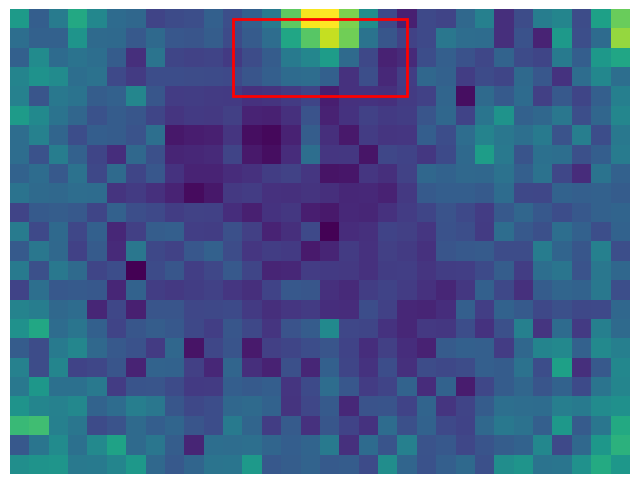

In [94]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
# numbers =dataset['numbers']
bboxes = dataset['bboxes']
cls = dataset['cls']

boxes = bboxes[0]
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images[0]
# print(image.shape)
plt.imshow(images[0])
ax = plt.gca()
boxes = tf.stack([
	boxes[:, 0] * images.shape[2],
	boxes[:, 1] * images.shape[1],
	boxes[:, 2] * images.shape[2],
	boxes[:, 3] * images.shape[1]], axis = -1
)

# print(boxes)
for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()
# print(cls[0])

In [95]:
import os
import random
import numpy as np
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = images.shape[0]
# N_TRAIN = int(images.shape[0] * 0.7)
# N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

# print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
# print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
# print("N_DATA:          ", N_DATA)
# print("N_TRAIN:         ", N_TRAIN)

shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]


cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [96]:
import os
import random
import numpy as np
import tensorflow as tf


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


In [97]:

for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id, dtype=tf.int32)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [98]:
import os
import random
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
# N_EPOCHS = 100
# N_BATCH = 8
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = image / tf.reduce_max(image)
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int32)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label

# cur_dir = os.getcwd()
# tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
# tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

# val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
# val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)


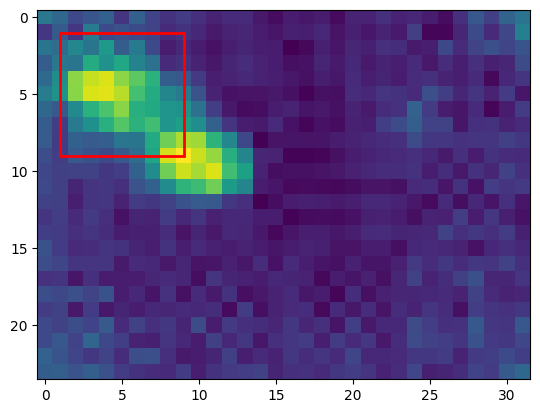

In [99]:
import matplotlib.pyplot as plt

for image, bbox, label in train_dataset.take(1):
    image = image.numpy()
    # print(image.shape)
    # print(label)
    # plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()  
    # print(bbox)

    boxes = tf.stack(
    	[
    	 bbox[:,0] * image.shape[1],
    	 bbox[:,1] * image.shape[0],
    	 bbox[:,2] * image.shape[1],
    	 bbox[:,3] * image.shape[0]
    	], axis = -1
    )
    # print(image.shape)
    # print(boxes)
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [100]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [101]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )

In [102]:
# for image, bbox, label in train_dataset.take(1):
#     # print(bbox)
#     # print(convert_to_xywh(bbox))

In [103]:
def resize_and_pad_image(image, min_side=96, max_side=128):
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)

    new_image_shape = ratio * image_shape

    image = tf.image.resize(image, 
                            tf.cast(new_image_shape, dtype=tf.int32), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image, new_image_shape, ratio


In [104]:
def preprocess_data(image, gt_boxes, cls_ids):
    # image = sample["images"]
    # bbox = sample["bboxes"]
    cls_ids = tf.cast(cls_ids, dtype = tf.int32)
    image, image_shape, _ = resize_and_pad_image(image)
    
    bbox = tf.stack([
        gt_boxes[:, 0] * image_shape[1],
        gt_boxes[:, 1] * image_shape[0],
        gt_boxes[:, 2] * image_shape[1],
        gt_boxes[:, 3] * image_shape[0]],
        axis = -1
    )
    
    bbox = convert_to_xywh(bbox)

    return image, bbox, cls_ids

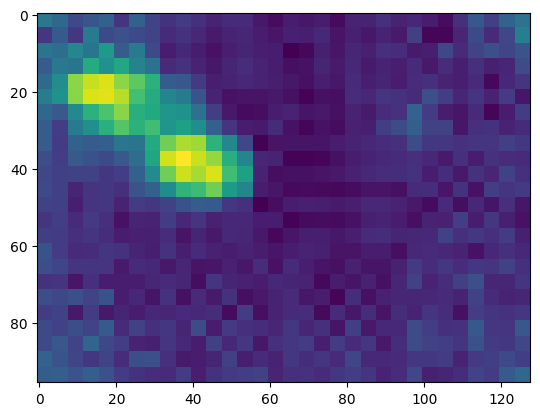

In [105]:
for image, bbox, label in train_dataset.take(1):
    image, _, _ = resize_and_pad_image(image)

# print(image.shape)
plt.imshow(image)
plt.show()


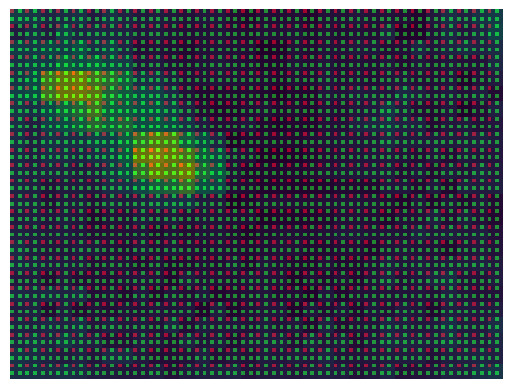

In [106]:
for image, bbox, label in train_dataset.take(1):
    # print(label)
    img, bbox, class_id = preprocess_data(image, bbox, label)
    # print(img.shape) # (72, 96, 1)

    anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
    # print(anchor_img.shape)

    # print(bbox)

    strides = [2, 4]
    colors = {
        2: [0, 255, 0],  # 초록색
        4: [255, 0, 0],  # 파란색
        # 16: [255, 0, 0],   # 빨간색
        # 32:[255, 255, 255],  # 노란색
        # 64:[255, 255, 0],  # 노란색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(img, alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    # print(tf.reduce_max(image), tf.reduce_min(image))

tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[20. 20. 32. 32.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.019607844, shape=(), dtype=float32)
bbox:  tf.Tensor(
[[ 4.  4. 36. 36.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


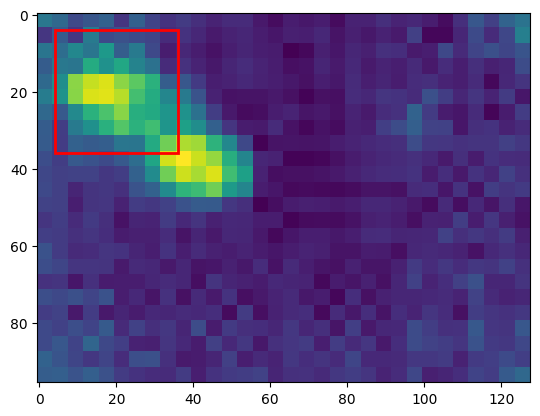

tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)


In [107]:
for image, bbox, label in train_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    print(label)
    print(box)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    w = img.shape[1]
    h = img.shape[0]
    boxes = tf.stack(
        [
            box[:, 0] - 0.5 * box[:, 2] ,  # xmin = x_center - width/2
            box[:, 1] - 0.5 * box[:, 3] ,  # ymin = y_center - height/2
            box[:, 0] + 0.5 * box[:, 2] ,  # xmax = x_center + width/2
            box[:, 1] + 0.5 * box[:, 3]    # ymax = y_center + height/2
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        w, h = xmax - xmin, ymax - ymin
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)

    plt.show()
    print(label)


In [108]:
class AnchorBox:
    def __init__(self):
        # self.aspect_ratios = [0.75, 1.0, 1.3, 1.5]        
        self.aspect_ratios = [0.93, 1.25, 1.43]        
        # self.scales = [2** x for x in [4/6, 5/6, 6/6]]
        self.scales = [2** x for x in [7/9, 8/9]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(2, 3)]
        self._areas = [x ** 2 for x in [16.3]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 2]
        centers = tf.expand_dims(centers, axis = -2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])

        dims = tf.tile(
            self._anchor_dims[level - 2], [feature_height, feature_width, 1, 1] 
        )
        
        anchors = tf.concat([centers, dims], axis=-1) 

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), 
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(2, 3)
        ]
        anchors = tf.concat(anchors, axis=0)
        # anchors = tf.clip_by_value(anchors, 0, [image_height, image_width, image_height, image_width])

        # image_width = tf.cast(image_width, tf.float32)
        # image_height = tf.cast(image_height, tf.float32)

        # new_anchors = tf.stack([
        #     anchors[:, 0] / image_width,
        #     anchors[:, 1] / image_height,
        #     anchors[:, 2] / image_width,
        #     anchors[:, 3] / image_height
        # ], axis=-1)

        return anchors

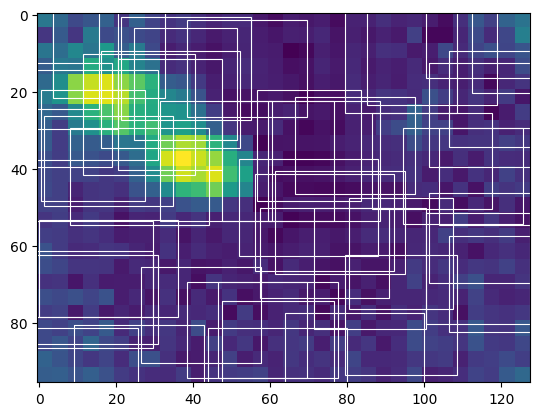

In [109]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()

    plt.imshow(img)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np
    # print(sample_data)
    for center_x, center_y, width, height in sample_data:
        top_left_x = (center_x - width / 2) 
        top_left_y = (center_y - height / 2)
        width = width
        height = height
        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

anchors = AnchorBox()
anchor = anchors.get_anchors(96, 128)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
# print("Anchor 음수 값:", has_negative_values.numpy())
# print("Anchor Shape:", anchor.shape)
draw_bounding_boxes(anchor, 50)


In [110]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    # # print("boxes1: ", boxes1)
    # print("boxes1_corners: ", boxes1_corners)
    boxes2_corners = convert_to_corners(boxes2)
    # # print("boxes2: ", boxes2)
    # print("boxes2_corners: ", boxes2_corners)
    boxes1_corners = tf.cast(boxes1_corners, tf.float32)
    boxes2_corners = tf.cast(boxes2_corners, tf.float32)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    # # print("lu: ", lu)
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    # # print("rd: ", rd)


    intersection = tf.maximum(rd - lu, 0.0)
    # # print("intersection: ", intersection)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    # # print("intersection_area: ", intersection_area)
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    
    boxes1_area = tf.cast(boxes1_area, tf.float32)
    boxes2_area = tf.cast(boxes2_area, tf.float32)
    intersection_area = tf.cast(intersection_area, tf.float32)

    
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    union_area = tf.cast(union_area, tf.float32)
    # print("union_area: ", union_area)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [111]:
GA = np.array([[0.75, 0.85416669, 0.11092302, 0.11831788]])
GT = np.array([[0.75, 0.85416669, 0.06819523, 0.12123596]])

print(compute_iou(GA, GT))

tf.Tensor([[0.60561454]], shape=(1, 1), dtype=float32)


In [112]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.7, ignore_iou = 0.6):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)

        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        box_target = box_target / self._box_variance
        return box_target
    
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        
        # cls_target = tf.cast(cls_target, tf.int32)
        # cls_target = tf.one_hot(cls_target, depth=3)
        
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
        # batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [113]:
# label_encoder = LabelEncoder()

# for image, bbox, label in train_dataset.take(1):
#     image, bbox, label = preprocess_data(image, bbox, label)
#     image = tf.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
#     bbox = tf.reshape(bbox, (1, bbox.shape[0], bbox.shape[1]))
#     label = tf.reshape(label, (1, label.shape[0]))
#     print(image.shape, bbox.shape, label.shape)
    
#     batch_img, batch_labels = label_encoder.encode_batch(image, bbox, label)
#     print(batch_labels.shape)

#     # 배치에서 첫 번째 이미지와 라벨 선택
#     # imgs = batch_img[0]
#     # labels = batch_labels[0, :, :4]  # xcenter, ycenter, w, h
    
#     # # 라벨에서 임의로 1000개 샘플 선택
#     labels = np.array(labels)
#     sampled_indices = np.random.choice(len(labels), min(1000, len(labels)), replace=False)
#     sample_data = labels[sampled_indices]

#     # 이미지와 사각형 표시
#     fig, ax = plt.subplots()
#     plt.imshow(batch_img[0])  # 그레이스케일 이미지라고 가정
#     for center_x, center_y, width, height in sample_data:
#         top_left_x = (center_x - width / 2)
#         top_left_y = (center_y - height / 2)
#         width = width
#         height = height
#         rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
#         ax.add_patch(rect)
    
#     plt.show()

#     print(batch_labels[0, :, :4])
#     print(batch_labels[0, :, 4:])

In [114]:

# # print("Eager execution: ", tf.executing_eagerly())
# if not tf.executing_eagerly():
#     tf.compat.v1.enable_eager_execution()

In [115]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
num_classes = 1
batch_size = 5


train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
# train_dataset = train_dataset.shuffle(batch_size * 8)

# train_dataset.batch(
#     batch_size = batch_size,
#     drop_remainder = True
# )

# train_dataset = train_dataset.padded_batch(
#     batch_size=batch_size, 
#     padded_shapes = ([96, 128, 1], [4, 4], [4]),
#     padding_values=(0.0, 1e-8, -2), 
#     drop_remainder=True


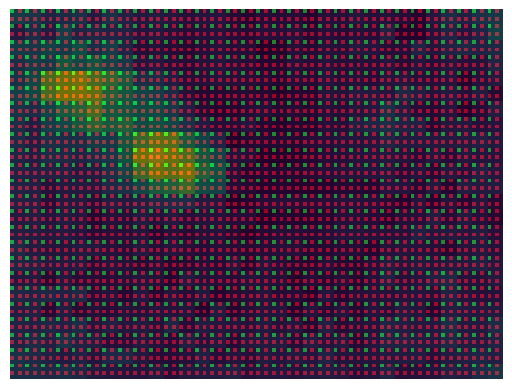

In [116]:
for image, bbox, label in train_dataset.take(1):
    # print(img.shape) # (72, 96, 1)

    anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)

    # print(bbox)
    # print(convert_to_corners(bbox))
    strides = [2 ** i for i in range(1, 3)]
    # print(strides)
    colors = {
        2: [255, 0, 0],  # 초록색
        4: [0, 255, 0],  # 초록색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(img, alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    # print(tf.reduce_max(image), tf.reduce_min(image))

In [117]:
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [118]:
batch_images = []
batch_labels = []
for img, bbox, label in train_dataset:
    img = tf.expand_dims(img, axis = 0)
    bbox = tf.expand_dims(bbox, axis = 0)
    label = tf.expand_dims(label, axis = 0)
    image, label = label_encoder.encode_batch(img, bbox, label)

    batch_images.append(image[0])
    batch_labels.append(label[0])

batch_images = np.array(batch_images)
batch_labels = np.array(batch_labels)
print(batch_images.shape)
print(batch_labels.shape)
new_dataset = tf.data.Dataset.from_tensor_slices((batch_images, batch_labels))


(3220, 96, 128, 1)
(3220, 4608, 5)


In [119]:
batch_size = 5
train_dataset = new_dataset.batch(
    batch_size = batch_size,
    drop_remainder = True
)
# train_dataset = train_dataset.prefetch(autotune)

In [120]:
# train_dataset에서 하나의 배치를 가져옵니다
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(4):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    labels[:, :, 4:]
    print(tf.reduce_max(images), tf.reduce_min(images))
    print(tf.reduce_max(labels), tf.reduce_min(labels))

    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(27.385834, shape=(), dtype=float32) tf.Tensor(-40.073772, shape=(), dtype=float32)
Positive 개수: 970
Negative 개수: 21218
Ignore 개수: 852
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(42.300095, shape=(), dtype=float32) tf.Tensor(-42.300095, shape=(), dtype=float32)
Positive 개수: 1738
Negative 개수: 19930
Ignore 개수: 1372
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(40.073772, shape=(), dtype=float32) tf.Tensor(-40.815884, shape=(), dtype=float32)
Positive 개수: 1309
Negative 개수: 20642
Ignore 개수: 1089
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(43.78431, shape=(), dtype=float32) tf.Tensor(-40.815884, shape=(), dtype=float32)
Positive 개수: 1080
Negative 개수: 20958
Ignore 개수: 1002


In [121]:
q!

SyntaxError: invalid syntax (3888922174.py, line 1)

In [ ]:
# def count_classes(tensor, positive=1, negative=2, ignore=3):
#     # 텐서를 정수로 변환
#     tensor_int = tf.argmax(tensor, axis=1) + 1  # 클래스 인덱스가 0부터 시작하므로 1을 더함

#     # 각 클래스에 대한 개수 계산
#     positive_count = tf.reduce_sum(tf.cast(tf.equal(tensor_int, positive), tf.int32))
#     negative_count = tf.reduce_sum(tf.cast(tf.equal(tensor_int, negative), tf.int32))
#     ignore_count = tf.reduce_sum(tf.cast(tf.equal(tensor_int, ignore), tf.int32))

#     return positive_count.numpy(), negative_count.numpy(), ignore_count.numpy()

(96, 128, 1)


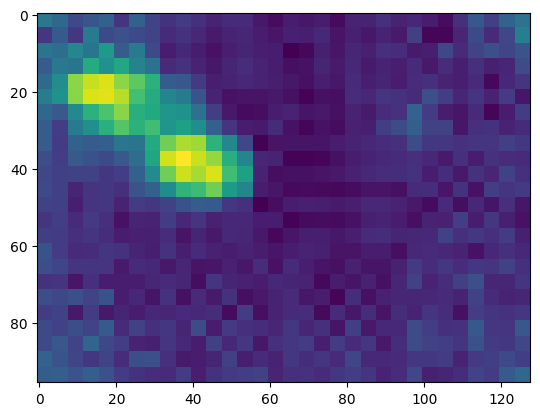

In [122]:
for img, label in new_dataset.take(1):
    img = img.numpy()  
    print(img.shape)
    plt.imshow(img)
    plt.show() 
    # label = tf.expand_dims(label, axis = 0)
    # print(label[:, :, 4:])
    # positive_count, negative_count, ignore_count = count_classes(label[:, 4:])
    # print(positive_count, negative_count, ignore_count)        



In [ ]:
# for batch_img, batch_labels in train_dataset.take(1):
#     # 배치에서 첫 번째 이미지와 라벨 선택
#     imgs = batch_img[0]
#     labels = batch_labels[0, :, :4]  # xcenter, ycenter, w, h
    
#     # # 라벨에서 임의로 1000개 샘플 선택
#     labels = np.array(labels)
#     sampled_indices = np.random.choice(len(labels), min(100, len(labels)), replace=False)
#     sample_data = labels[sampled_indices]

#     # 이미지와 사각형 표시
#     fig, ax = plt.subplots()
#     plt.imshow(imgs)  # 그레이스케일 이미지라고 가정
#     for center_x, center_y, width, height in sample_data:
#         top_left_x = (center_x - width / 2) * 128
#         top_left_y = (center_y - height / 2) * 96
#         width = width * 128
#         height = height * 96
#         rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
#         ax.add_patch(rect)
    
#     plt.show()


# # 850

In [ ]:
# from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
# from keras.layers import Input, GlobalAveragePooling2D, Conv2D, ReLU, Reshape, Multiply
# from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
# from keras.models import Model
# from keras.layers import ZeroPadding2D, DepthwiseConv2D
# from keras.regularizers import l2
# from keras.layers import Add
# import tensorflow as tf

# class BackBone(tf.keras.Model):
#     def __init__(self):
#         super(BackBone, self).__init__()
#         # self.l2_regularizer = l2(0.001)

#     def squeeze_excite_block(self, input_tensor, ratio=8):
#         """ Squeeze and Excitation block """
#         channels = input_tensor.shape[-1]

#         x = GlobalAveragePooling2D()(input_tensor)
#         x = Reshape((1, 1, channels))(x)

#         x = Conv2D(channels // ratio, (1, 1), padding='same')(x)
#         x = ReLU()(x)
#         x = Conv2D(channels, (1, 1), padding='same')(x)
#         x = tf.keras.activations.sigmoid(x)
#         out = Multiply()([input_tensor, x])
#         return out

#     def residual_layer(self, feature_map, latent, name:str):
#         """ Residual block """
#         add_layer = Add(name = name+'_output')([feature_map, latent])
#         return add_layer

#     def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
#         feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_1')(feature_map)
#         feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_2')(feature_map)
#         feature_map = BatchNormalization()(feature_map)
#         feature_map = Activation('relu')(feature_map)
#         feature_map = DepthwiseConv2D(kernel_size=3, padding = 'same')(feature_map)
#         feature_map = BatchNormalization()(feature_map)
        
#         # upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (3, 3), padding = 'same')(inputs_image)
#         # feature_map = Dropout(0.3)(feature_map)

#         feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_3')(feature_map)
#         feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_4')(feature_map)
#         feature_map = BatchNormalization()(feature_map)
#         feature_map = Activation('relu')(feature_map)
#         feature_map = self.squeeze_excite_block(feature_map)
#         return feature_map

#     def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
#         latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_1')(feature_map)
#         latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_2')(feature_map)
#         latent = BatchNormalization()(latent)
#         latent = Activation('relu')(latent)
#         latent = DepthwiseConv2D(kernel_size=3, padding = 'same')(latent)
#         # feature_map = Dropout(0.3)(feature_map)

#         latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_3')(latent)
#         latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
#                         # kernel_regularizer=self.l2_regularizer,
#                         name = name+'_4')(latent)
#         latent = BatchNormalization()(latent)
#         latent = Activation('relu')(latent)
#         # latent = DepthwiseConv2D(kernel_size=3, padding = 'same')(latent)
#         residual_block = self.residual_layer(feature_map, latent, name)
#         return residual_block
    
#     def __call__(self, input_shape=(96, 128, 1)):
#         inputs_image = Input(shape=input_shape)
        
#         # inputs_image = ZeroPadding2D(((2, 2),(0, 0)))(inputs_image)
#         block_1 = self.feature_extraction_block(inputs_image, 4, 8, 'block_1')
#         block_1_output = self.convolutional_residual_block(block_1, 4, 8,'block_2')
#         block_2 = self.feature_extraction_block(block_1_output, 4, 8, 'block_3')
#         block_2_output = self.convolutional_residual_block(block_2, 4, 8, 'block_4')
#         block_3 = self.feature_extraction_block(block_2_output, 4, 8, 'block_5')
#         block_3_output = self.convolutional_residual_block(block_3, 4, 8, 'block_6')
#         block_4 = self.feature_extraction_block(block_3_output, 4, 8, 'block_7')
#         block_4_output = self.convolutional_residual_block(block_4, 4, 8, 'block_8')

#         model = Model(inputs_image, block_4_output)
#         return model

In [ ]:
# backbone = BackBone()
# model = backbone()
# model.summary()

In [123]:
import keras

def get_backbone():
    # 사전 훈련된 모델 로드
    backbone = keras.models.load_model('ObjectDetectionCheckpoint/BackBone/backbone_best_model.h5')

    # 원하는 레이어의 출력 추출
    b2_output, b4_output, b6_output, b8_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['block_2_output', 'block_4_output', 'block_6_output', 'block_8_output']
    ]

    # 새로운 모델 생성
    return keras.Model(
        inputs=backbone.inputs, outputs=[b2_output, b4_output, b6_output, b8_output]
    )


In [ ]:
# q!

In [ ]:
# backbone = get_backbone()
# backbone.summary()

In [124]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import Input, GlobalAveragePooling2D, Conv2D, ReLU, Reshape, Multiply
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D, DepthwiseConv2D, Concatenate
from keras.regularizers import l2
from keras.layers import Add
import tensorflow as tf

class FeaturePyramid(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = get_backbone()
        self.conv_p2_3x3 = keras.layers.Conv2D(filters = 8, 
                                               kernel_size = 3, 
                                               strides = 2, 
                                               padding = "same")
        
        self._p2_conv_3x3_out = keras.layers.Conv2D(filters = 8, 
                                                    kernel_size = 3, 
                                                    strides = 1, 
                                                    padding = "same")

        self.b8_2x = keras.layers.Conv2DTranspose(filters = 8, 
                                                  kernel_size = 3, 
                                                  strides = 2 , 
                                                  padding = 'same')
        
        self.b6_2x = keras.layers.Conv2DTranspose(filters = 8, 
                                                  kernel_size = 3, 
                                                  strides = 2 , 
                                                  padding = 'same')
        
        self.b4_2x = keras.layers.Conv2DTranspose(filters = 8, 
                                                  kernel_size = 3, 
                                                  strides = 2 , 
                                                  padding = 'same')
        





        self.p6_2x = keras.layers.Conv2DTranspose(filters = 16, 
                                                  kernel_size = 3, 
                                                  strides = 2 , 
                                                  padding = 'same')
        
        self.p6_4x = keras.layers.Conv2DTranspose(filters = 16, 
                                                  kernel_size = 3, 
                                                  strides = 4 , 
                                                  padding = 'same')
        

        self.p4_2x = keras.layers.Conv2DTranspose(filters = 8, 
                                                  kernel_size = 3, 
                                                  strides = 2 , 
                                                  padding = 'same')


        self.se_conv1x1_1 = Conv2D(1, (1, 1), padding='same')
        self.se_conv1x1_2 = Conv2D(8, (1, 1), padding='same')
    
        self.batchnorm_p8 = BatchNormalization()
        self.batchnorm_p6 = BatchNormalization()
        self.batchnorm_p4 = BatchNormalization()
        self.batchnorm_p2 = BatchNormalization()

        self.batchnorm_final_p4 = BatchNormalization()
        self.batchnorm_final_p2 = BatchNormalization()
        self.depth_2d = keras.layers.DepthwiseConv2D(kernel_size=3, padding = 'same')

        self.concat_p6 = Concatenate()
        self.concat_p4 = Concatenate()
        self.concat_p2 = Concatenate()
        self.concat_p4_out = Concatenate()

        self.concat_p2_out = Concatenate()
        

    def squeeze_excite_block(self, input_tensor, ratio=4):
        channels = input_tensor.shape[-1]
        x = GlobalAveragePooling2D()(input_tensor)
        x = Reshape((1, 1, channels))(x)

        x = self.se_conv1x1_1(x)
        x = ReLU()(x)
        x = self.se_conv1x1_2(x)
        x = Activation('sigmoid')(x)
        out = Multiply()([input_tensor, x])
        return out
    

    def call(self, images, training=True):
        b2_output, b4_output, b6_output, b8_output = self.backbone(images, training=training)
    #  (48, 64, 8)(24, 32, 8)(12, 16, 8) (6, 8, 8)
        # p8_output = self.squeeze_excite_block(b8_output)
        # p8_output = self.batchnorm_p8(p8_output)
        
        # p6_output = self.squeeze_excite_block(b6_output)
        # p6_output = self.batchnorm_p6(p6_output)
        
        # p4_output = self.squeeze_excite_block(b4_output)
        # p4_output = self.batchnorm_p4(p4_output)
        
        # p2_output = self.squeeze_excite_block(b2_output)
        # p2_output = self.batchnorm_p2(p2_output)
        
        p6_output = self.concat_p6([b6_output, self.b8_2x(b8_output)]) # 16
        p6_output = self.batchnorm_p6(p6_output) # (12, 16, 16)

        p4_output = self.concat_p4([b4_output, self.b6_2x(b6_output)]) # 16
        p4_output = self.batchnorm_p4(p4_output) # (24, 32, 16)

        p2_output = self.concat_p2([b2_output, self.b4_2x(b4_output)]) # 16
        p2_output = self.batchnorm_p2(p2_output) # (48, 64, 16)
        
        p4_output = self.concat_p4_out([self.p6_2x(p6_output), p4_output, self.conv_p2_3x3(p2_output)])
        
        # p2_output = self.concat_p2_out([self.p6_4x(p6_output), self.b4_2x(p4_output), self._p2_conv_3x3_out(p2_output)])

        p4_output = self.batchnorm_final_p4(p4_output)
        # p2_output = self.batchnorm_final_p2(p2_output)

        return p4_output

In [125]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 40])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01, seed=1)

    # for _ in range(1):
    
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.BatchNormalization())
    head.add(keras.layers.ReLU())
    head.add(keras.layers.DepthwiseConv2D(kernel_size=3, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.BatchNormalization())
    head.add(keras.layers.ReLU())
    head.add(keras.layers.DepthwiseConv2D(kernel_size=3, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.Conv2D(4, 8, padding = 'same', kernel_initializer=kernel_init))
    head.add(keras.layers.BatchNormalization())
    head.add(keras.layers.ReLU())
    
        

    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [126]:
class CustomNet(keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(CustomNet, self).__init__(name="CustomNet", **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(6 * num_classes, prior_probability)
        self.box_head = build_head(6 * 4, "zeros")

    def call(self, image, training=True):
        # # # # # # print(f"shape: {image.shape}")
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]

        # tf.print(features.shape)
        # for feature in features:
        box_output = tf.reshape(self.box_head(features), [N, -1, 4])
        cls_output = tf.reshape(self.cls_head(features), [N, -1, self.num_classes])
        cls_output = tf.nn.softmax(cls_output) 
        # box_outputs.append(box_output)
        # cls_outputs.append(cls_output)
        
        # cls_outputs = tf.concat(cls_outputs, axis=1)
        # box_outputs = tf.concat(box_outputs, axis=1)
        # final_output = tf.concat([box_outputs, cls_outputs], axis=-1)
        # return final_output
        final_output = tf.concat([box_output, cls_output], axis=-1)  # Shape: (N, 18432, 7)

        return final_output

In [127]:
class CustomNetBoxLoss(tf.losses.Loss):  
    def __init__(self, delta):
        super(CustomNetBoxLoss, self).__init__(
            reduction="none", name="CustomNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )

        return tf.reduce_sum(loss, axis=-1)

In [128]:
# class CustomNetClassificationLoss(tf.losses.Loss):
#     def __init__(self):
#         super(CustomNetClassificationLoss, self).__init__(
#             reduction="none", name="CustomNetClassificationLoss"
#         )

#     def call(self, y_true, y_pred):
#         cls_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
#         # [배치 크기, 앵커 박스의 수] 형태를 유지하도록 변경
#         return cls_loss


In [129]:
class CustomNetClassificationLoss(tf.losses.Loss):   
    def __init__(self, alpha, gamma):
        super(CustomNetClassificationLoss, self).__init__(
            reduction="none", name="CustomNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

        return tf.reduce_sum(loss, axis=-1)

In [130]:
# class CustomNetLoss(tf.losses.Loss):    
#     def __init__(self):
#         super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]
        
#         box_loss = tf.keras.losses.mean_squared_error(box_labels, box_predictions)
#         box_loss = tf.reduce_sum(box_loss, axis=-1)
#         box_loss = box_loss / tf.reduce_max(box_loss)

        
#         cls_loss = cls_loss / tf.reduce_max(cls_loss)
        
#         combined_loss = box_loss + cls_loss
#         return combined_loss / 2

In [131]:
# class CustomNetLoss(tf.losses.Loss):    
#     def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
#         super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")
#         self._cls_loss = CustomNetClassificationLoss()
#         self._box_loss = CustomNetBoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]

#         cls_labels = y_true[:, :, 4:]
#         # tf.print(cls_labels.shape)
#         cls_predictions = y_pred[:, :, 4:]
#         # tf.print(cls_predictions.shape)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         box_loss = box_loss / tf.reduce_max(box_loss)
#         cls_loss = cls_loss / tf.reduce_max(cls_loss)
#         loss = cls_loss + box_loss
#         return loss

In [132]:
# class CustomNetLoss(tf.losses.Loss):    
#     def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
#         super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")
#         self._cls_loss = CustomNetClassificationLoss()
#         self._box_loss = CustomNetBoxLoss(delta)
#         self._num_classes = num_classes

#     def call(self, y_true, y_pred):
#         y_pred = tf.cast(y_pred, dtype=tf.float32)
#         box_labels = y_true[:, :, :4]
#         box_predictions = y_pred[:, :, :4]

#         cls_labels = y_true[:, :, 4:]
#         cls_predictions = y_pred[:, :, 4:]

#         positive_mask = tf.cast(tf.equal(tf.argmax(cls_labels, axis=-1), 0), dtype=tf.float32)
#         ignore_mask = tf.cast(tf.equal(tf.argmax(cls_labels, axis=-1), 2), dtype=tf.float32)

#         cls_loss = self._cls_loss(cls_labels, cls_predictions)
#         box_loss = self._box_loss(box_labels, box_predictions)

#         cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
#         box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
#         normalizer = tf.reduce_sum(positive_mask, axis=-1)

#         cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
#         box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
#         loss = cls_loss + box_loss
#         return loss


In [133]:
class CustomNetLoss(tf.losses.Loss):    
    def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
        super(CustomNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._cls_loss = CustomNetClassificationLoss(alpha, gamma)
        self._box_loss = CustomNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = cls_loss + box_loss
        return loss

In [134]:
LR = 0.0005
initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

model_dir = "ObjectDetectionCheckpoint/customnet.ckpt"

In [135]:
from keras.metrics import Precision, Recall

# # # # 멀티 GPU 전략 설정
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     # 모델, 손실 함수, 옵티마이저를 전략 범위 내에서 정의
#     model = CustomNet(num_classes)
#     loss_fn = CustomNetLoss()
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

#     # 모델 컴파일
#     model.compile(optimizer=optimizer, 
#                   loss=loss_fn,
#                   metrics=['accuracy', Precision(), Recall()])


num_classes = 1

model = CustomNet(num_classes)
loss_fn = CustomNetLoss()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# 모델 컴파일
model.compile(optimizer=optimizer, 
              loss=[loss_fn],
              metrics=['accuracy', Precision(), Recall()])


In [136]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]

In [137]:
import tensorflow as tf

tf.config.run_functions_eagerly(False)

In [138]:
train_dataset = train_dataset.prefetch(autotune)
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset = train_dataset.with_options(options)

autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(autotune)


In [139]:
# for batch in train_dataset.take(5):
#     images, labels = batch
#     print(labels.shape)

#     positive_count, negative_count, ignore_count = count_classes(labels[0, :, 4:])
#     print(positive_count, negative_count, ignore_count)    


In [140]:
# train_dataset에서 하나의 배치를 가져옵니다
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -2.0), tf.int32))

print("Positive 개수:", positive_count.numpy())
print("Negative 개수:", negative_count.numpy())
print("Ignore 개수:", ignore_count.numpy())


(5, 4608, 5)
Positive 개수: 970
Negative 개수: 21218
Ignore 개수: 852


In [141]:
# train_dataset에서 하나의 배치를 가져옵니다
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    
    # 이미지와 레이블의 형태를 출력합니다
    print("Images shape:", images.shape)
    print("Images max:", tf.reduce_max(images))
    print("Images min:", tf.reduce_min(images))
    print("Labels shape:", labels.shape)

Images shape: (5, 96, 128, 1)
Images max: tf.Tensor(1.0, shape=(), dtype=float32)
Images min: tf.Tensor(0.0, shape=(), dtype=float32)
Labels shape: (5, 4608, 5)


In [142]:
epochs = 400

model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/100


2024-01-26 06:19:19.052164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-26 06:19:20.409933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4471d18040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-26 06:19:20.409961: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-26 06:19:20.409967: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-26 06:19:20.409970: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-26 06:19:20.409973: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-26 06:19:20.409976: I tensorflow/compiler/xla/service/service

643/644 [============================>.] - ETA: 0s - loss: 12.4560 - accuracy: 0.1094 - precision_1: 0.9963 - recall_1: 0.2726
Epoch 1: loss improved from inf to 12.45704, saving model to ObjectDetectionCheckpoint/customnet.ckpt/weights_epoch_1
644/644 [==============================] - 51s 37ms/step - loss: 12.4570 - accuracy: 0.1095 - precision_1: 0.9963 - recall_1: 0.2727
Epoch 2/100
644/644 [==============================] - ETA: 0s - loss: 12.0642 - accuracy: 0.1364 - precision_1: 0.9959 - recall_1: 0.2933
Epoch 2: loss improved from 12.45704 to 12.06421, saving model to ObjectDetectionCheckpoint/customnet.ckpt/weights_epoch_2
644/644 [==============================] - 24s 37ms/step - loss: 12.0642 - accuracy: 0.1364 - precision_1: 0.9959 - recall_1: 0.2933
Epoch 3/100
643/644 [============================>.] - ETA: 0s - loss: 11.9686 - accuracy: 0.1412 - precision_1: 0.9959 - recall_1: 0.3027
Epoch 3: loss improved from 12.06421 to 11.96990, saving model to ObjectDetectionCheckpo

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def draw_bounding_boxes(image, detections):
#     """
#     이미지에 바운딩 박스를 그립니다.
#     detections: 예측된 바운딩 박스와 클래스 점수가 포함된 배열
#     """
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)

#     # 바운딩 박스 추출 및 그리기
#     for detection in detections:
#         bbox, scores = detection[:4], detection[4:]
#         class_id = np.argmax(scores)  # 가장 높은 점수를 가진 클래스 ID
#         print(class_id)
#         # 사람 클래스(0번)에 해당하는 바운딩 박스만 그립니다.
#         if class_id == 0:
#             x_center, y_center, width, height = bbox
#             xmin = (x_center - width / 2) 
#             ymin = (y_center - height / 2)
#             width = width
#             height = height
#             print(xmin, ymin, width, height)
#             rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
#             ax.add_patch(rect)
#             break
#     plt.show()


In [ ]:
# def prepare_image(image):
#     image, _, ratio = resize_and_pad_image(image)
#     image = tf.keras.applications.resnet.preprocess_input(image)
#     return tf.expand_dims(image, axis=0), ratio



# for imgs, labels in train_dataset.take(1):
#     print(tf.reduce_max(imgs), tf.reduce_min(imgs))
#     detections = model.predict(imgs[0:1])
#     detections = np.array(detections)
#     print(detections.shape)
#     # print(detections[0, :, :4])
#     # print(detections[0, :, 4:])
#     draw_bounding_boxes(imgs[0], detections[0])
#     # positive_count = tf.reduce_sum(tf.cast((detections[:, :, 4] > 0.5), tf.int32))
#     # print(positive_count)
#     # print(detections.nmsed_boxes[0][:num_detections])
#     # print(detections.nmsed_scores[0][:num_detections])
#     class_names = [
#         "person"
#     ]
#     # visualize_detections(
#     #     imgs[0],
#     #     detections.nmsed_boxes[0][:num_detections] / 4,
#     #     class_names,
#     #     detections.nmsed_scores[0][:num_detections],
#     # )

In [ ]:
# np.array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00]).argmax() + 1

In [ ]:
# 0.0000000e+00+8.9468936e-24+1.0000000e+00